In [1]:
# fit PCA on the hormone data with speed as exogenous variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster

In [2]:
figures_dir = '../../figures/fig3/'

In [3]:
# load data
horm_beh = np.load('../../data/processed/compounds_aligned_speed.npy', allow_pickle=True).item()
X1m = horm_beh['X1m'].T
X1a = horm_beh['X1a'].T
X2m = horm_beh['X2m'].T
X2a = horm_beh['X2a'].T
X3 = horm_beh['X3'].T
y1m = horm_beh['y1m']
y1a = horm_beh['y1a']
y2m = horm_beh['y2m']
y2a = horm_beh['y2a']
y3 = horm_beh['y3']
common_comps = horm_beh['common_comps']

In [4]:
# robust z-score each individual compound per animal first
def robust_zscore(data, axis=0, log_transform=False):
    if log_transform:
        data = np.log(data)
    median = np.nanmedian(data, axis=axis)
    mad = np.nanmedian(np.abs(data - median), axis=axis)
    zscore = (data - median) / mad
    return zscore

X1 = robust_zscore(np.concatenate([X1m, X1a], axis=0)) 
X2 = robust_zscore(np.concatenate([X2m, X2a], axis=0))
X3 = robust_zscore(X3)

y1 = np.concatenate([y1m, y1a], axis=0)
y2 = np.concatenate([y2m, y2a], axis=0)
y3 = y3

# concatenate data after z-scoring each animal individually
X = np.concatenate([X1, X2, X3], axis=0)
y = np.concatenate([y1, y2, y3], axis=0)
n_samples, n_features = X.shape

# print shapes to check consistency
print(X.shape, y.shape)

(164, 123) (164,)


## Spearman correlation matrices, clustering, and controls

In [5]:
# cluster spearman correlation matrix into 6 clusters using hierarchical clustering
Z = linkage(spearmanr(X)[0], method='ward')
clusters = fcluster(Z, 5, criterion='maxclust')

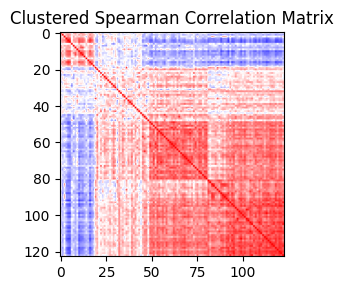

In [6]:
# plot matrix reordered according to cluster identity
def plot_clustered_corr(corr, clusters):
    # order by clusters
    order = np.argsort(clusters)
    clustered_corr = corr[order][:, order]
    plt.figure(figsize=(3, 3))
    plt.imshow(clustered_corr, vmin=-1, vmax=1, cmap='bwr')
    plt.title('Clustered Spearman Correlation Matrix')
    plt.tight_layout()
plot_clustered_corr(spearmanr(X)[0], clusters)

In [7]:
# compute within block vs outside block correlations
def compute_block_correlations(mat, clusters):
    within_block_corrs = []
    outside_block_corrs = []
    for i in range(1, 6):
        block_indices = clusters == i
        outside_indices = clusters != i
        block_corrs = mat[:, block_indices][block_indices]
        outside_corrs = mat[:, outside_indices][block_indices]
        # get upper triangle values excluding diagonal
        within_block_corrs.extend(block_corrs[np.triu_indices_from(block_corrs, k=1)])
        outside_block_corrs.extend(outside_corrs.flatten())
    return np.median(within_block_corrs)/np.median(outside_block_corrs)

In [8]:
compute_block_correlations(spearmanr(X)[0], clusters)

np.float64(3.4760972830693055)

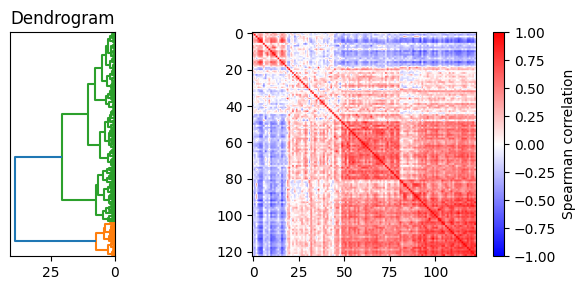

In [9]:
# same as above but also add dendrogram to the side!!
from scipy.cluster.hierarchy import dendrogram
def plot_clustered_corr_with_dendrogram(corr, clusters):
    # order by clusters
    order = np.argsort(clusters)
    clustered_corr = corr[order][:, order]
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 4]})
    dendrogram(linkage(corr, method='ward'), ax=ax[0], orientation='left', no_labels=True)
    ax[0].set_title('Dendrogram')
    im = ax[1].imshow(clustered_corr, vmin=-1, vmax=1, cmap='bwr')
    # ax[1].set_title('Clustered Spearman Correlation Matrix')
    fig.colorbar(im, ax=ax[1], label='Spearman correlation', fraction=0.046, pad=0.04)
    plt.tight_layout()
plot_clustered_corr_with_dendrogram(spearmanr(X)[0], clusters)
plt.savefig(figures_dir+'clustered_spearman_corr_matrix_with_dendrogram.pdf', dpi=300)

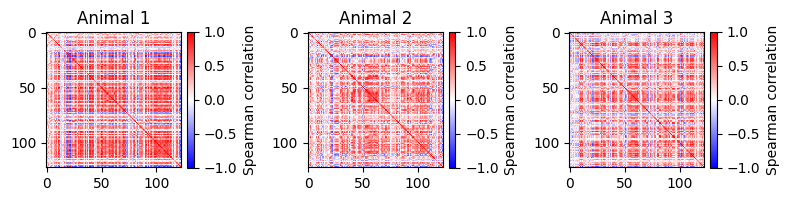

Cosine similarity between spearman correlation matrices:
[0.63829095 0.67790716 0.57471102]
Animal 1 blockiness: 4.745179063360882
Animal 2 blockiness: 3.7251440922190198
Animal 3 blockiness: 3.24546553808948


In [10]:
# per animal spearman correlation matrices
def plot_spearman_corr(X, title):
    corr, _ = spearmanr(X)
    plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar(label='Spearman correlation', fraction=0.046, pad=0.04)
    plt.title(title)
    
plt.figure(figsize=(8, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_spearman_corr([X1, X2, X3][i], f'Animal {i + 1}')
plt.tight_layout()
plt.savefig(figures_dir+'spearman_corr_matrices.pdf', dpi=300)
plt.show()

# compute cosine similarity across the three spearman correlation matrices
rs = [spearmanr(Xi)[0] for Xi in [X1, X2, X3]]
sim_matrix = cosine_similarity([r.flatten() for r in rs])
print("Cosine similarity between spearman correlation matrices:")
print(sim_matrix[np.triu_indices(3, k=1)])
# compute blockiness for each animal
for i, Xi in enumerate([X1, X2, X3]):
    r = spearmanr(Xi)[0]
    blockiness = compute_block_correlations(r, clusters)
    print(f"Animal {i + 1} blockiness: {blockiness}")

In [11]:
# partial correlation between compounds in X taking into account y
# i.e. compute correlation between residuals of X after regressing out y

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import pacf

def comp_resids(X, y): # compute residuals of each compound in X after regressing out y
    n_compounds = X.shape[1]
    resids = np.zeros_like(X)
    for i in range(n_compounds):
        model = LinearRegression().fit(y.reshape(-1, 1), X[:, i])
        resids[:, i] = X[:, i] - model.predict(y.reshape(-1, 1))
    return resids

def partial_corr(X, y):
    n_compounds = X.shape[1]
    resids = comp_resids(X, y)
    p_corr = np.zeros((n_compounds, n_compounds))
    for i in range(n_compounds):
        for j in range(n_compounds):
            if i == j:
                p_corr[i, j] = 1.0
            else:
                # compute correlation between residuals
                # p_corr[i, j] = np.corrcoef(resids[:, i], resids[:, j])[0, 1]
                # use robust Spearman correlation instead of Pearson
                p_corr[i, j] = spearmanr(resids[:, i], resids[:, j])[0]
    return p_corr

# compute partial correlation for each compound in each dataset
pacs = {}
for name, data, speed in zip(['X1', 'X2', 'X3'], [X1, X2, X3], [y1, y2, y3]):
    pacs[name] = partial_corr(data, speed)

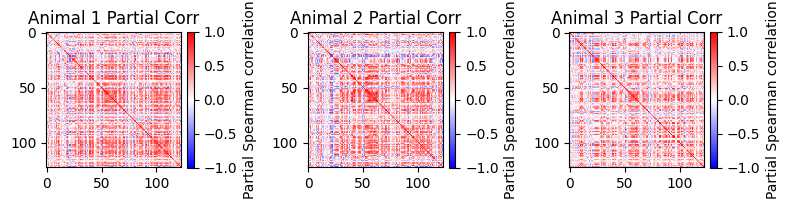

Cosine similarity between spearman correlation matrices:
[0.62366347 0.64371312 0.53169263]
Animal 1 partial correlation blockiness: 3.9318706697459587
Animal 2 partial correlation blockiness: 4.119067103109656
Animal 3 partial correlation blockiness: 4.126930637461387


In [12]:
# plot the three partial correlation matrices
import matplotlib.pyplot as plt
def plot_partial_corr(p_corr, title):
    plt.imshow(p_corr, vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar(label='Partial Spearman correlation', fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
plt.figure(figsize=(8, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_partial_corr(pacs[f'X{i + 1}'], f'Animal {i + 1} Partial Corr')
plt.savefig(figures_dir+'partial_spearman_corr_matrices.pdf', dpi=300)
plt.show()
# compute cosine similarity across the three partial spearman correlation matrices
sim_matrix = cosine_similarity([r.flatten() for r in pacs.values()])
print("Cosine similarity between spearman correlation matrices:")
print(sim_matrix[np.triu_indices(3, k=1)])
# compute blockiness for each animal
for i, name in enumerate(['X1', 'X2', 'X3']):
    r = pacs[name]
    blockiness = compute_block_correlations(r, clusters)
    print(f"Animal {i + 1} partial correlation blockiness: {blockiness}")

### Extra step, column normalize and check consistency

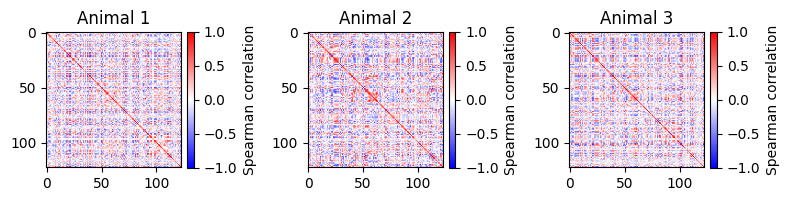

In [13]:
# compute the spearman r for X1, X2, and X3 with the columns normalized
X1n = robust_zscore(X1.T, log_transform=False).T
X2n = robust_zscore(X2.T, log_transform=False).T
X3n = robust_zscore(X3.T, log_transform=False).T

plt.figure(figsize=(8, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_spearman_corr([X1n, X2n, X3n][i], f'Animal {i + 1}') 
plt.savefig(figures_dir+'spearman_corr_matrices_Columns_norm.pdf', dpi=300)
plt.tight_layout()
plt.show()

SignificanceResult(statistic=np.float64(0.8086997484726586), pvalue=np.float64(0.0)) SignificanceResult(statistic=np.float64(0.8604904248061116), pvalue=np.float64(0.0)) SignificanceResult(statistic=np.float64(0.8465801161000015), pvalue=np.float64(0.0))


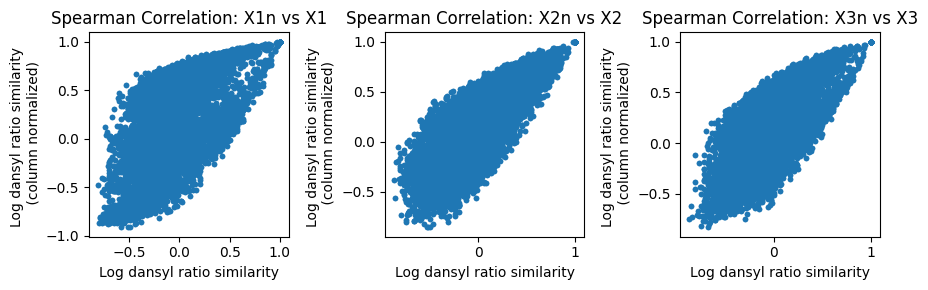

In [14]:
plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spearmanr([X1n,X2n,X3n][i])[0].flatten(), spearmanr([X1,X2,X3][i])[0].flatten(),marker='.',rasterized=True)
    plt.xlabel('Log dansyl ratio similarity')
    plt.ylabel('Log dansyl ratio similarity \n (column normalized)')
    plt.title(f'Spearman Correlation: X{i+1}n vs X{i+1}')
    plt.tight_layout()
plt.savefig(figures_dir+'spearman_corr_scatter_X2n_vs_X2.pdf', dpi=300)
print(spearmanr(X1n.flatten(), X1.flatten()),spearmanr(X2n.flatten(), X2.flatten()),spearmanr(X3n.flatten(), X3.flatten()))

# Interactions across compounds / partial xcorrs

In [15]:
# compute residuals of X1 vs y1, X2 vs y2, X3 vs y3
X1_resids = comp_resids(X1, y1)
X2_resids = comp_resids(X2, y2)
X3_resids = comp_resids(X3, y3)
X_resids = np.concatenate([X1_resids, X2_resids, X3_resids], axis=0)

In [16]:
# spearman R cross correlation
def spearman_ccf(x, y, max_lag):
    lags = np.arange(-max_lag+1, max_lag)
    ccf = [spearmanr(x[max_lag+lag:-max_lag+lag], 
                     y[max_lag: -max_lag])[0] for lag in lags]
    return lags, ccf

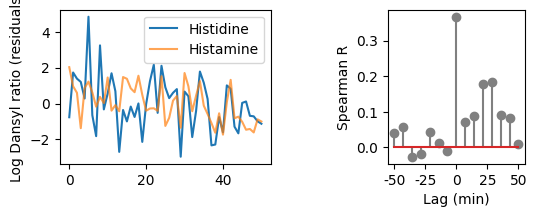

In [17]:
# plot histamine and histidine residuals time series, xcorr
histamine_idx = common_comps.index('Histamine')
histidine_idx = common_comps.index('Histidine')

plt.figure(figsize=(6, 2))
plt.subplot(121)
histidine_idx = common_comps.index('Histidine')
plt.plot(X2_resids[:, histidine_idx], label='Histidine')
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X2_resids[:, histamine_idx], label='Histamine', alpha=0.7  )
plt.legend()

plt.subplot(133)
histidine_idx = common_comps.index('Histidine')
histamine_idx = common_comps.index('Histamine')
lags, ccf_histamine_histidine = spearman_ccf(X_resids[:, histidine_idx],X_resids[:, histamine_idx],max_lag=8)
# stem with color grey
plt.stem(lags, ccf_histamine_histidine, linefmt='grey', markerfmt='o')
plt.xticks([-7,-3.5,0,3.5,7], [-50,-25,0,25,50])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig(figures_dir+'histamine_histidine_ccg.pdf', dpi=300)

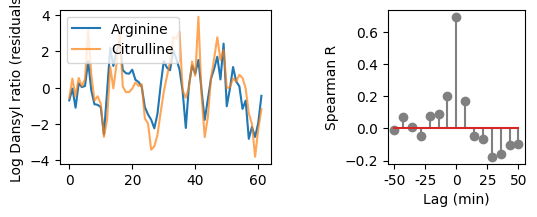

In [18]:
# same for arginine and citrulline
arginine_idx = common_comps.index('Arginine')
citrulline_idx = common_comps.index('Citrulline')

plt.figure(figsize=(6, 2))
plt.subplot(121)
plt.plot(X3_resids[:, arginine_idx], label='Arginine')
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, citrulline_idx], label='Citrulline', alpha=0.7  )
plt.legend()    

plt.subplot(133)
lags, ccf_arginine_citrulline = spearman_ccf(X_resids[:, arginine_idx],X_resids[:, citrulline_idx],max_lag=8)
plt.stem(lags, ccf_arginine_citrulline, linefmt='grey', markerfmt='o')
plt.xticks([-7,-3.5,0,3.5,7], [-50,-25,0,25,50])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig(figures_dir+'arginine_citrulline_ccg.pdf', dpi=300)

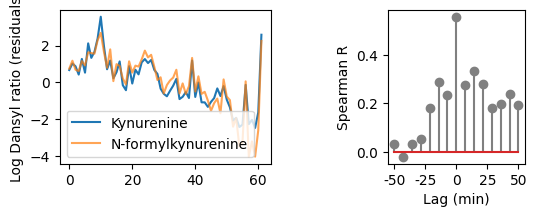

In [19]:
# Kynurenine and n-formylynurenine
plt.figure(figsize=(6, 2))
kynurenine_idx = common_comps.index('Kynurenine')
nformylynurenine_idx = common_comps.index('N-formylkynurenine')
plt.subplot(121)
plt.plot(X3_resids[:, kynurenine_idx], label='Kynurenine')
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, nformylynurenine_idx], label='N-formylkynurenine', alpha=0.7  )
plt.legend()

plt.subplot(133)
lags, ccf_kynurenine_nformylynurenine = spearman_ccf(X_resids[:, kynurenine_idx],X_resids[:, nformylynurenine_idx],max_lag=8)
plt.stem(lags, ccf_kynurenine_nformylynurenine,linefmt='grey', markerfmt='o')
plt.xticks([-7,-3.5,0,3.5,7], [-50,-25,0,25,50])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig(figures_dir+'kynurenine_nformylynurenine_ccg.pdf', dpi=300)



# rPCA analyses

In [21]:
# import robust, Spearman based PCA
import SpearmanPCA

In [22]:
rpca = SpearmanPCA.SpearmanRobustPCA(
    n_components=20,
    gaussianize=True,   # rank → normal scores
    center='median',
    scale='mad',
    handle_missing='pairwise',
    whiten=False
)
X_reduced = rpca.fit_transform(X)

In [23]:
rpca.explained_variance_ratio_

array([0.35916835, 0.09324903, 0.06058375, 0.05287716, 0.04187403,
       0.03103364, 0.03028649, 0.02810705, 0.02189727, 0.01911881,
       0.01614226, 0.01488853, 0.01377479, 0.01288021, 0.0114516 ,
       0.0109414 , 0.01027723, 0.00975661, 0.00778025, 0.00728441])

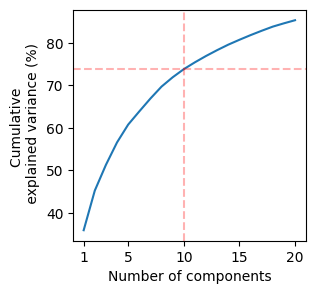

In [25]:
plt.figure(figsize=(3, 3))
plt.plot(np.cumsum(rpca.explained_variance_ratio_)*100)
plt.xlabel('Number of components')
plt.ylabel('Cumulative \n explained variance (%)')
plt.axvline(x=9, color='r', alpha=0.3, linestyle='--')
plt.axhline(y=np.sum(rpca.explained_variance_ratio_[0:10])*100, color='r', alpha=0.3, linestyle='--')
plt.xticks([0,4,9,14,19],[1,5,10,15,20])
plt.savefig(figures_dir+'rpca_explained_variance.pdf', dpi=300)

In [33]:
np.sum(rpca.explained_variance_ratio_[0:10])*100

np.float64(73.81955782804886)

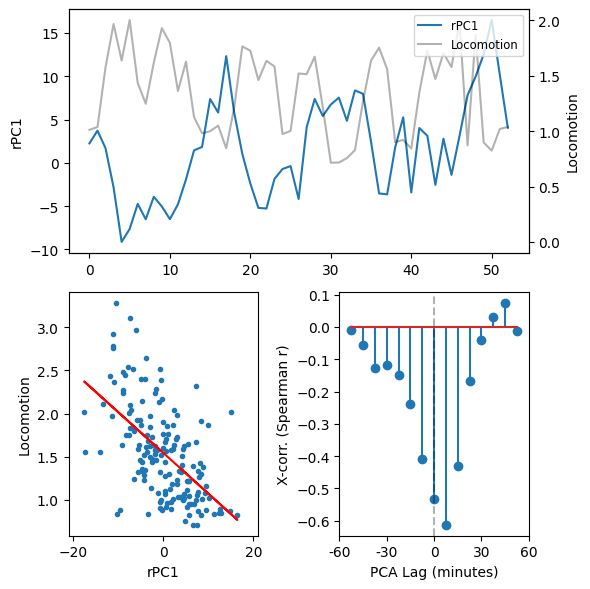

In [27]:
# scatter plot y vs first two principal components
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(X_reduced[111:, 0]) # animal 3, starting from index 111
plt.ylabel('rPC1')
plt.twinx()
plt.plot(0,0,label='rPC1')
plt.plot(y[111:], color='k',alpha=0.3, label='Locomotion') # example of animal 3, starting from index 111
plt.ylabel('Locomotion')
plt.legend(loc='upper right', fontsize='small')
plt.subplot(2, 2, 3)
plt.scatter(X_reduced[:, 0],y,rasterized=True,marker='.')
m, b = np.polyfit(X_reduced[:, 0], y, 1)
plt.plot(X_reduced[:, 0], m*X_reduced[:, 0] + b, color='red')
plt.xlim(-21,21)
plt.xlabel('rPC1')
plt.ylabel('Locomotion')

plt.subplot(2, 2, 4)

# cross-correlation of first PC with behavior
maxlag = 8
# plt.xcorr(X_reduced[:, 2], y, maxlags=maxlag)
plt.stem(*spearman_ccf(X_reduced[:, 0], y, max_lag=maxlag))
plt.xticks(np.arange(-maxlag, maxlag + 1, 4), labels=(np.arange(-maxlag, maxlag + 1, 4)*7.5).astype(int))   
plt.xlabel('PCA Lag (minutes)')
plt.ylabel('X-corr. (Spearman r)')
plt.axvline(0, color='k', linestyle='--',alpha=0.3)

plt.tight_layout()

plt.savefig(figures_dir+'rPCA1_vs_Locomotion.pdf', dpi=300)

plt.show()

In [28]:
spearmanr(X_reduced[1:, 0], y[:-1])

SignificanceResult(statistic=np.float64(-0.6406581652728593), pvalue=np.float64(3.2719963875442696e-20))

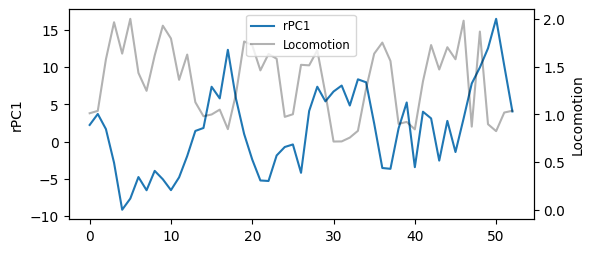

In [29]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(X_reduced[111:, 0])
plt.ylabel('rPC1')
plt.twinx()
plt.plot(0,0,label='rPC1')
plt.plot(y[111:], color='k',alpha=0.3, label='Locomotion')
plt.ylabel('Locomotion')
plt.legend(loc=9,fontsize='small')
# plt.savefig('PCA_vs_Locomotion_animal3.pdf', dpi=300)

In [30]:
# loading analyses of PC1 -- which compounds have strong loadings?
loadings = rpca.components_.T  # shape (n_features, n_components)
pc1_loadings = loadings[:, 0]  # first principal component loadings
# sort by absolute value of loadings
sorted_indices = np.argsort(np.abs(pc1_loadings))[::-1]
sorted_loadings = pc1_loadings[sorted_indices]
sorted_compounds = np.array(common_comps)[sorted_indices]

In [31]:
sorted_compounds[:20], sorted_loadings[:20]

(array(['Threonine', 'Lysyl-Glutamic acid', 'Proline',
        'Methionyl-Glutamic acid',
        'Glutamyl-Methionine/Methionyl-Glutamic acid', 'Alanine',
        'Asparagine', 'Serine', 'Histidine', 'Glutamyl-Alanine',
        'Glutamyl-Phenylalanine', 'Phenylalanine', 'Pantothenic acid',
        'Glutamic acid/L-4-Hydroxyglutamate semialdehyde', 'Arginine',
        'Prolyl-Proline', 'Isomer 2 of 5-Aminopentanoic acid',
        'Aminoadipic acid', 'L-Cysteinylglycine disulfide',
        '3-Hydroxy-L-proline'], dtype='<U50'),
 array([-0.13577371, -0.132923  , -0.13234506, -0.131023  , -0.13095175,
        -0.129501  , -0.1286959 , -0.12830991, -0.12730873, -0.12561192,
        -0.12459891, -0.12296898, -0.12295365, -0.11945745, -0.11930032,
        -0.11880653, -0.11861425, -0.11762744, -0.11694405, -0.11674678]))

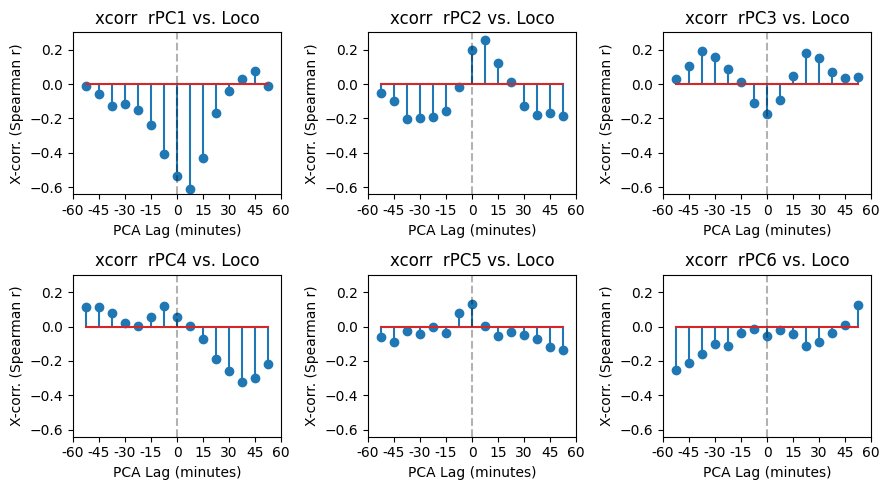

In [34]:
# same for second, third and 4th PC
plt.figure(figsize=(9, 5))
for p in range(6):
    plt.subplot(2,3,p+1)
    # plt.xcorr(X_reduced[:, p], y, maxlags=maxlag)
    plt.stem(*spearman_ccf(X_reduced[:, p], y, max_lag=maxlag))
    plt.xticks(np.arange(-maxlag, maxlag + 1, 2), labels=(np.arange(-maxlag, maxlag + 1, 2)*7.5).astype(int))   
    plt.xlabel('PCA Lag (minutes)')
    plt.ylabel('X-corr. (Spearman r)')
    plt.title(f'xcorr  rPC{p+1} vs. Loco')
    plt.axvline(0, color='k', linestyle='--',alpha=0.3)
    plt.ylim(-0.64,0.3)
plt.tight_layout()
plt.savefig(figures_dir+'PCA_vs_Locomotion_multiple_PCs.pdf', dpi=300)
plt.show()